# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

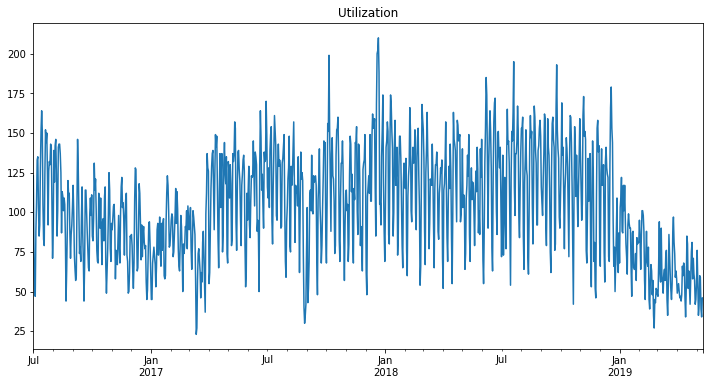

In [4]:
ax = apap_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

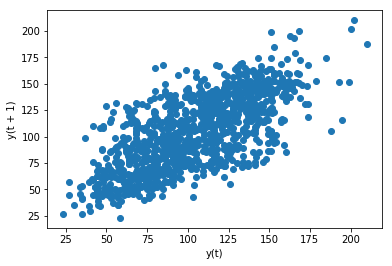

In [6]:
lag_plot(apap_daily["Doses"]);

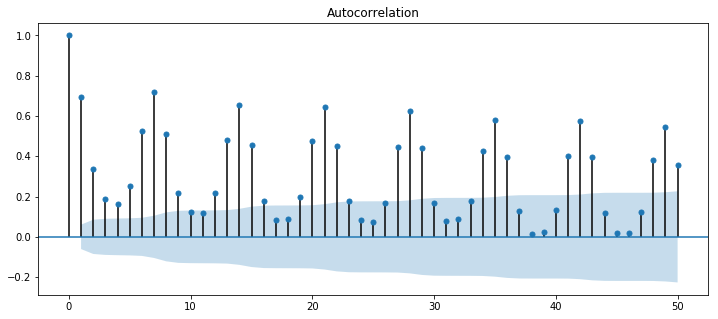

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_acf(apap_daily["Doses"], lags=50, ax=ax);
#plot_acf(apap_daily);

In [8]:
# data is not stationary; p-value > 0.05
adfuller(apap_daily["Doses"].dropna(), autolag='AIC')[1]

0.2978121675515909

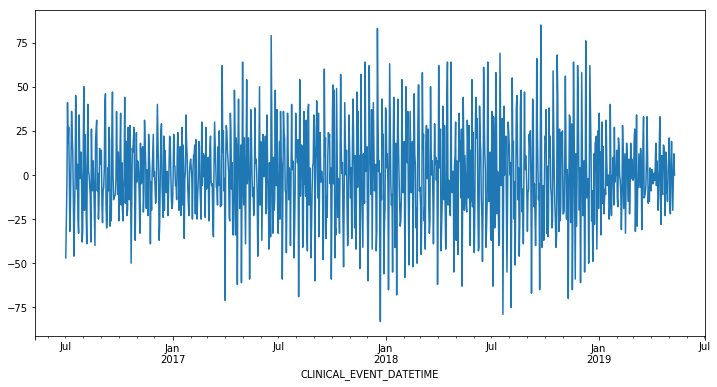

In [9]:
# difference the data to make it stationary
df_diff = apap_daily.copy()
df_diff["Doses"] = diff(apap_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [10]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

3.674029188920869e-19

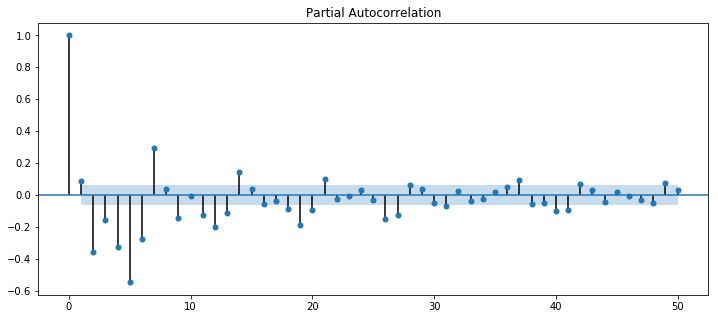

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# RNN

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.


In [13]:
n_inputs = 60
n_features = 1
n_valid = 7
n_pred = 30
batch_size = 1

In [14]:
df = apap_daily
#df = df_diff.dropna()
l = len(df) - n_pred
train_set = df.iloc[:l]
train = df.iloc[:l - n_valid]
valid = df.iloc[l - n_inputs - n_valid:l]
test_set = df.iloc[l:]

In [22]:
scaler = MinMaxScaler()
scaler.fit(train_set)
scaled_train = scaler.transform(train)
scaled_valid = scaler.transform(valid)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
#gen_train = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=batch_size)

In [31]:
#for i in range(len(gen_train)):
#    x, y = gen_train[i]
#    print('%s => %s' % (x, y))

In [69]:
#gen_valid = TimeseriesGenerator(scaled_valid, scaled_valid, length=n_inputs, batch_size=batch_size)

In [16]:
features_set = []  
labels = []  
for i in range(n_inputs, len(train_set)):  
    features_set.append(scaled_train_set[i - n_inputs:i, 0])
    labels.append(scaled_train_set[i, 0])

In [17]:
features_set, labels = np.array(features_set), np.array(labels) 

In [20]:
features_set.shape

(955, 60)

In [28]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], n_features))  

In [31]:
# int(len(apap_daily) / (2 * (n_inputs + n_features)))
n_nodes = int(2/3 * (n_inputs + n_features))

In [32]:
model = Sequential()
#model.add(LSTM(n_nodes, activation="relu", input_shape=(n_inputs, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(n_nodes, input_shape=(features_set.shape[1], n_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(features_set, labels, epochs=100, batch_size=30) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
955/955 [==============================] - 6s 6ms/step - loss: 0.0717
Epoch 2/100
955/955 [==============================] - 3s 3ms/step - loss: 0.0266
Epoch 3/100
955/955 [==============================] - 3s 4ms/step - loss: 0.0254
Epoch 4/100
955/955 [==============================] - 3s 4ms/step - loss: 0.0263
Epoch 5/100
955/955 [==============================] - 3s 4ms/step - loss: 0.0253
Epoch 6/100
955/955 [==============================] - 3s 3ms/step - loss: 0.0244
Epoch 7/100
955/955 [==============================] - 4s 4ms/step - loss: 0.0251
Epoch 8/100
955/955 [==============================] - 4s 4ms/step - loss: 0.0251
Epoch 9/100
955/955 [==============================] - 3s 4ms/step - loss: 0.0246
Epoch 10/100
955/955 [==============================] - 4s 4ms/step - loss: 0.0250
Epoch 11/100
955/955 [==============================] - 3s 3ms/step - loss: 0.0231
Epoch 12/100
955/955 [==========================

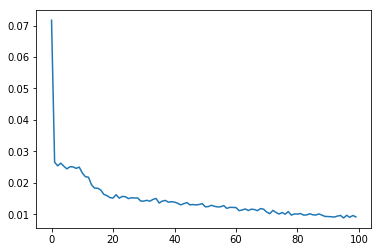

In [34]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [35]:
test_inputs = apap_daily.iloc[len(train_set) - n_inputs:].values
# last 90 of train plus 90 test

In [36]:
test_inputs = test_inputs.reshape(-1, 1)  
test_inputs = scaler.transform(test_inputs) 

In [38]:
test_features = []  
for i in range(n_inputs, len(test_inputs)):  
    test_features.append(test_inputs[i - n_inputs:i, 0])
# gets the previous 90 values for each value in test set

In [39]:
test_features = np.array(test_features) 
test_features.shape

(30, 60)

In [41]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], n_features))  
test_features.shape

(30, 60, 1)

In [47]:
test_features

array([[[0.26737968],
        [0.34759358],
        [0.2459893 ],
        ...,
        [0.22994652],
        [0.19786096],
        [0.24064171]],

       [[0.34759358],
        [0.2459893 ],
        [0.22994652],
        ...,
        [0.19786096],
        [0.24064171],
        [0.22994652]],

       [[0.2459893 ],
        [0.22994652],
        [0.29411765],
        ...,
        [0.24064171],
        [0.22994652],
        [0.12299465]],

       ...,

       [[0.13903743],
        [0.20320856],
        [0.21925134],
        ...,
        [0.19786096],
        [0.19251337],
        [0.0855615 ]],

       [[0.20320856],
        [0.21925134],
        [0.18181818],
        ...,
        [0.19251337],
        [0.0855615 ],
        [0.05882353]],

       [[0.21925134],
        [0.18181818],
        [0.26203209],
        ...,
        [0.0855615 ],
        [0.05882353],
        [0.12299465]]])

In [43]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)  

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


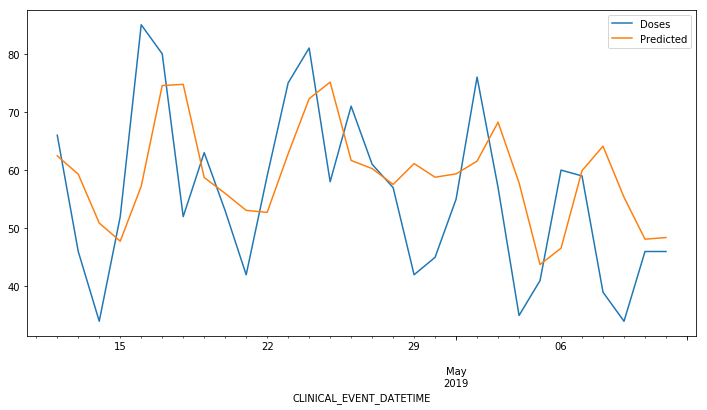

In [45]:
test_set["Predicted"] = predictions
test_set.plot(legend=True, figsize=(12,6));

In [46]:
mse_rnn = mean_squared_error(test_set["Doses"], test_set["Predicted"])
rmse_rnn = rmse(test_set["Doses"],  test_set["Predicted"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 177.3743735
RMSE RNN: 13.31819708


# Forecast

In [101]:
n_fcast = 90
new_preds = []
first_batch = scaler.transform(df[-n_inputs:])
current_batch = first_batch.reshape((batch_size, n_inputs, n_features))

for i in range(n_fcast):
    current_pred = model.predict(current_batch)[0]
    new_preds.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [102]:
unscaled_preds = scaler.inverse_transform(new_preds)
undiff_preds = apap_daily["Doses"].iloc[-1] + unscaled_preds.cumsum()
df_preds = pd.DataFrame(undiff_preds, columns=["Predictions"])
idx = pd.date_range(apap_daily.index[-1] + 1, periods = n_fcast, freq="D")
df_preds.index = idx

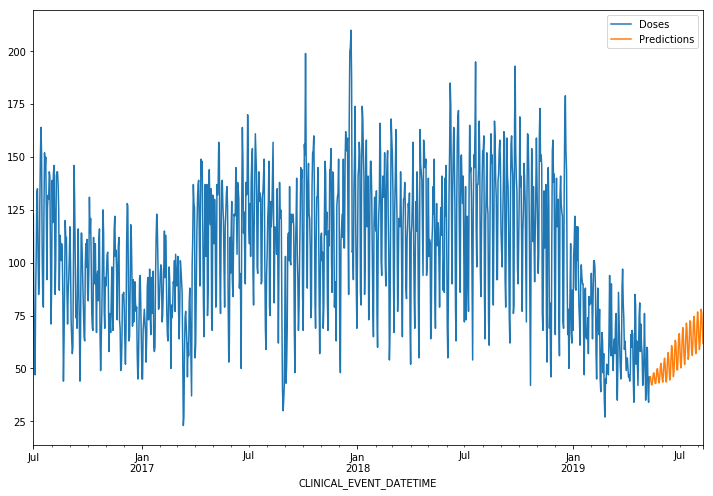

In [103]:
ax = apap_daily["Doses"].plot(figsize=(12, 8), legend=True)
df_preds["Predictions"].plot(legend=True);
ax.autoscale(axis='x',tight=True)

In [104]:
model.save("acetaminophen_rnn_1-layer.h5")

In [24]:
df_preds.columns = ["Doses"]
apap_monthly = [apap_daily, df_preds]
apap_monthly = pd.concat(apap_monthly)
apap_monthly = apap_monthly.loc[:"2020-04-30"].resample("MS").sum()

In [90]:
#apap_monthly

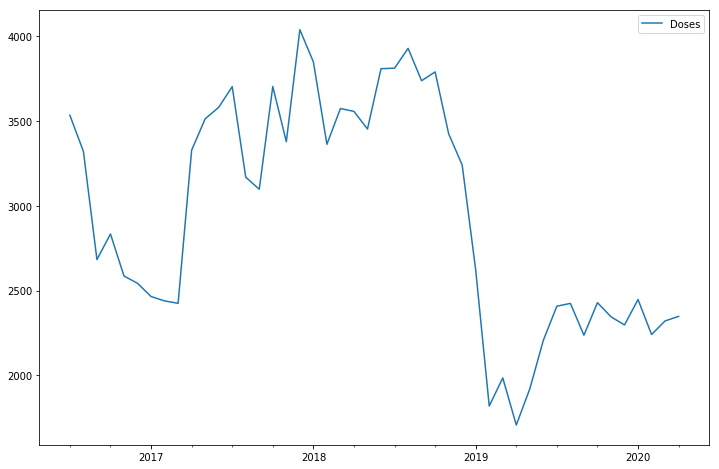

In [26]:
apap_monthly.plot(figsize=(12, 8))